In [ ]:
s = 500

In [ ]:
s = int(s)
print(s)

In [3]:
!date

Tue Mar 22 12:49:02 EDT 2022


In [4]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [5]:
%%time
import numpy as np
import pandas as pd
import os
import ants
from matplotlib import pyplot as plt

#from tqdm.notebook import tqdm as tqdm
from tqdm import tqdm

CPU times: user 2.58 s, sys: 5.23 s, total: 7.81 s
Wall time: 7.54 s


In [6]:
indir = '~/data/ABIDE/Derivatives/preprocessed/'
indir = os.path.expanduser(indir)

subjects = [subject for subject in os.listdir(indir) if subject.startswith('sub-')]
subjects.sort()
print(len(subjects))

1068


In [7]:
prefs = ['frc','rc','sfrc']

In [8]:
pref = prefs[0]
sub = subjects[s]

In [9]:
def get_epi(sub):
    indir = '~/data/ABIDE/Derivatives/preprocessed/'
    epi_path_temp = os.path.join(indir,'{subID}/{pref}-{subID}_bold.nii.gz')
    epi_path_temp = os.path.expanduser(epi_path_temp)
    im = ants.image_read(epi_path_temp.format(pref='sfrc',subID=sub))
    im = im.resample_image(resample_params=(64,64,64,im.shape[-1]), use_voxels=True, interp_type=4)
    return im

In [10]:
# def make_mean(epi_path_temp,sub):
#     im = ants.image_read(epi_path_temp.format(pref='raw',subID=sub))
#     mask = ants.image_read(epi_path_temp.format(pref='mask',subID=sub))
#     im3 = ants.slice_image(im,axis=3,idx=0).new_image_like(im.numpy().mean(axis=3))
#     im3[mask==0]=0
#     im3.to_filename(epi_path_temp.format(pref='raw',subID=sub).replace('raw','mean'))
# #[make_mean(epi_path_temp,sub) for sub in tqdm(subjects)]

In [11]:
# indir = '~/data/ABIDE/Derivatives/preprocessed/'
# epi_path_temp = os.path.join(indir,'{subID}/{pref}-{subID}_bold.nii.gz')
# epi_path_temp = os.path.expanduser(epi_path_temp)
# ims = [ants.image_read(epi_path_temp.format(pref='mean',subID=sub)) for sub in tqdm(subjects)]
# im64 = [im.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=4) for im in ims]

In [12]:
# im64_arr = np.array([im.numpy() for im in im64])
# im64_mean = im64[0].new_image_like(im64_arr.mean(axis=0))
# im64_mean.plot_ortho(flat=True)

In [13]:
def get_cmat(im,atlas):
    
    rois = np.unique(atlas.numpy().flatten().astype(int))
    rois = rois[rois!=0]

    assert len(rois)==max(rois),'where rois?'
    
    im_arr = im.numpy().reshape(-1,im.shape[-1]).transpose()
    atlas_arr = atlas.flatten()

    roi_timeseries = np.array([im_arr[:,atlas_arr==r].mean(axis=1) for r in rois])

    assert np.isnan(roi_timeseries).sum()==0,'nans in timeseries'

    return np.corrcoef(roi_timeseries)

In [21]:
def get_cmat_split(im,atlas):
    
    rois = np.unique(atlas.numpy().flatten().astype(int))
    rois = rois[rois!=0]

    assert len(rois)==max(rois),'where rois?'
    

    im_arr = im.numpy().reshape(-1,im.shape[-1]).transpose()
    atlas_arr = atlas.flatten()
    
    n = im_arr.shape[0]
    mid = int(n/2)
    
    
    im_arr1 = im_arr[0:mid-2,:]
    im_arr2 = im_arr[mid+2::,:]

    roi_timeseries1 = np.array([im_arr1[:,atlas_arr==r].mean(axis=1) for r in rois])
    roi_timeseries2 = np.array([im_arr2[:,atlas_arr==r].mean(axis=1) for r in rois])

    cmat1 = np.corrcoef(roi_timeseries1)
    cmat2 = np.corrcoef(roi_timeseries2)
    
    return np.array([cmat1,cmat2])

In [15]:
im = get_epi(sub)
im3 = ants.slice_image(im,axis=3,idx=0)

In [16]:
atlas = ants.image_read('../Data/YeoAtlas/Atlas_parc-7n_2mm.nii')
atlas = atlas.resample_image_to_target(im3,interp_type='genericLabel')
#atlas = atlas.resample_image(resample_params=(64,64,64), use_voxels=True, interp_type=1)

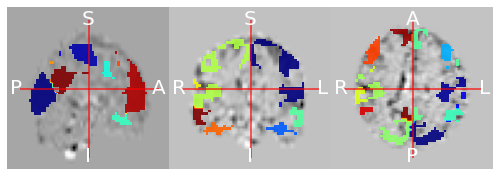

In [17]:
im3.plot_ortho(atlas,flat=True)

In [22]:
cmats = get_cmat_split(im,atlas)

In [23]:
v1 = cmats[0,:,:][np.triu_indices(n=cmats.shape[-1],k=1)]
v2 = cmats[1,:,:][np.triu_indices(n=cmats.shape[-1],k=1)]
np.corrcoef(v1,v2)[0,1]

0.34353628807148295

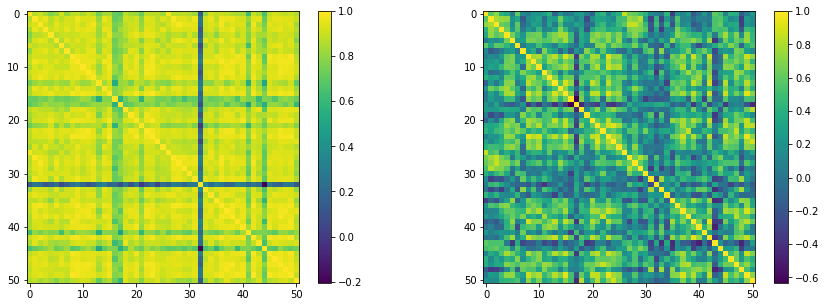

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cmats[0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cmats[1,:,:])
plt.colorbar()

In [25]:
ofdir = f'~/BC-fMRI-AE/Assets/ABIDE-I-rel-cmats-{pref}'
ofdir = os.path.expanduser(ofdir)

if not os.path.exists(ofdir):
    os.mkdir(ofdir)

In [26]:
ofn = os.path.join(ofdir,f'{sub}-rel-cmats-{pref}.npy')
print(ofn)
np.save(file=ofn,arr=cmats)

/data/aglinska/BC-fMRI-AE/Assets/ABIDE-I-rel-cmats-frc/sub-0050665-rel-cmats-frc.npy


In [ ]:
# for sub in tqdm(subjects):
    
#     ofn = f'~/BC-fMRI-AE/Assets/ABIDE-I-cmats-sfrc/{pref}-{sub}-cmat.npy'
#     ofn = os.path.expanduser(ofn)
    
#     if not os.path.exists(ofn):
#         try:
#             im = get_epi(sub)
#             cmat = get_cmat(im,atlas)
#             np.save(file=ofn, arr=cmat)
#         except:
#             print(f'{sub} errored')

In [ ]:
# temp = '~/data/ABIDE/Outputs/cpac/filt_noglobal/func_mean/'
# temp = os.path.expanduser(temp)

# fs = [f for f in os.listdir(temp) if f.endswith('.nii.gz')]
# fs.sort()

In [ ]:
# stuff = [ants.image_read(os.path.join(temp,f)) for f in tqdm(fs)]

In [ ]:
# sarr = np.array([s.numpy() for s in stuff])

In [ ]:
# stuff[0].new_image_like(sarr.mean(axis=0)).plot_ortho(flat=True)

In [ ]:
# scmat = np.corrcoef(np.array([np.array(sarr[i,:,:,:].flatten()) for i in range(sarr.shape[0])]))
# striu = scmat[np.triu_indices(n=scmat.shape[0],k=1)]